# Карьерный Цех — задание для аналитиков от 30 апреля 2021 — личный этап

Ссылка на полную версию задания: https://www.notion.so/30-2021-0be801732c9e4ad293ddf1c408394256

### Задание

**(*единственное в конкурсе, загрузите его решение целиком одним файлом)** 

[Сбермаркет](https://sbermarket.ru/) - сервис доставки продуктов на дом пользователю. 

Вы пошли на конференцию по маркетинговой аналитике и познакомились там с продакт-менеджером Сбермаркета, отвечающим за направление привлечения пользователей.

Его боль - поиск хорошего аналитика. Слово за слово, и вы выяснили, что на самом деле проблема достаточно конкретна. Продакт-менеджер проводил эксперимент с лэндингом, вместе с аналитиком, который должен был его обсчитать. Все шло хорошо, эксперимент был запущен и аналитик начал его обсчитывать. Но ознакомившись с данными сказал, что устал,  выгорел и ему нужен длительный ретрит. Что он и сделал, уехав в Тибет, без связи и интернета. 

Замену изнутри пообещали только через месяц - у всех свои планы и плотный график. Поэтому продакт упросил вас проанализировать этот эксперимент со стороны и посулил отличный гонорар. 

Ипотека сама себя не выплатит, поэтому вы согласились.

В качестве материалов, он кинул вам исходные данные с описанием дизайна эксперимента и выгрузки результатов.

### Import

In [141]:
import pandas as pd
import os

### Input

In [2]:
ab_test_hit = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'AB Test Hit.csv'))
add_to_cart_clicked = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Add To Cart Clicked.csv'))
address_change_initiated = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Address Change Initiated.csv'))
address_not_in_deli = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Address Not In Delivery Zone.csv'))
landing_viewed = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Landing Viewed.csv'))
main_viewed = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Main Page Viewed.csv'))
order_completed = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Order Completed.csv'))
product_added = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Product Added.csv'))
shop_selected = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Shop Selected.csv'))
shop_celection_started = pd.read_csv(os.path.join('E:', '_Work', 'Career factory', 'Shop Celection Started.csv'))

## Дизайн эксперимента (проблемы)

### Отсутствует описание критериев и метода разбиения пользователей на группы

In [142]:
# Всего пользователей AB Test Hit
ab_test_hit.drop_duplicates()['anonymous_id'].nunique()

489019

In [143]:
# Всего пользователей в Landing Viewed 
landing_viewed.drop_duplicates()['anonymous_id'].nunique()

210922

In [144]:
# Пользователей Landing Viewed из датасета AB Test Hit
landing_viewed[landing_viewed['anonymous_id'].isin(ab_test_hit['anonymous_id'])]['anonymous_id'].nunique()

210922

### Описаны не все модалки из эксперимента

In [146]:
address_change_initiated['source'].value_counts()

add_product             57265
address                 31360
landing                 13083
not_in_delivery_zone     1443
add_alcohol               283
Name: source, dtype: int64

In [147]:
shop_celection_started['source'].value_counts()

header           36553
address_modal    14290
landing           6564
Name: source, dtype: int64

In [148]:
shop_selected['source'].value_counts()

header           190608
address_modal     13596
landing            7524
Name: source, dtype: int64

### События, не предусмотренные дизайном для Default 

In [175]:
# этот шаг отсутствует в дизайне полностью. также значение значительно меньше, чем shop_selected
print('shop_selection_started:', shop_celection_started[shop_celection_started['anonymous_id'].\
                             isin(ab_test_hit[ab_test_hit['group'] == 'default']['anonymous_id'])].\
      groupby('anonymous_id').nunique().shape[0])


print('shop selected:', shop_selected[shop_selected['anonymous_id'].\
                             isin(ab_test_hit[ab_test_hit['group'] == 'default']['anonymous_id'])].\
      groupby('anonymous_id').nunique().shape[0])

shop_selection_started: 23055
shop selected: 43418


Прочие аномалии здесь или дальше по ходу решения

In [166]:
# Должно быть 0
shop_selected[(shop_selected['anonymous_id'].isin(default))
             &(shop_selected['source'] == 'landing')].groupby('anonymous_id').nunique().shape[0]

9

In [167]:
# Должно быть 0
shop_celection_started[(shop_celection_started['anonymous_id'].isin(default))
                       &(shop_celection_started['source'] == 'landing')].groupby('anonymous_id').nunique().shape[0]

9

## Предобработка данных
1. Уберем аномалии.
2. Почистим дубликаты исходя из предположения, что повторные посещения имеют перекос в сторону повышения конверсии и уменьшения отскока.

In [3]:
# Удалим дубликаты
ab_test_hit = ab_test_hit.drop_duplicates()

In [4]:
ab_test_hit.describe()

,hit_at,anonymous_id,group,device_type,browser,os
count,502784,502784,502784,502784,502784,502783
unique,502470,489019,2,5,37,15
top,2020-12-03 05:33:34.021 UTC,5bb785fd-e0e7-447a-b0e1-a06328b31cbe,default,mobile,Chrome,Android
freq,3,18,446474,305530,250245,195489


In [5]:
# Количество человек, включенных в обе группы
both_groups = ab_test_hit[['group','anonymous_id']].groupby('anonymous_id').nunique().reset_index()
both_groups = both_groups[both_groups['group'] > 1]
both_groups.shape[0]

528

In [6]:
# Example
ab_test_hit[ab_test_hit['anonymous_id'] == '0045db67-ef5c-4a6b-81b4-3e079d79b073']

,hit_at,anonymous_id,group,device_type,browser,os
96121,2020-12-05 09:55:34.775 UTC,0045db67-ef5c-4a6b-81b4-3e079d79b073,default,mobile,Chrome,Android
126053,2020-12-05 09:55:35.36 UTC,0045db67-ef5c-4a6b-81b4-3e079d79b073,address_first,mobile,Chrome,Android


Начинаем формировать датасет с очищенными данными, на основе которого потом будем строить воронку движения пользователя

In [7]:
ab_test_cleared = ab_test_hit[~ab_test_hit['anonymous_id'].isin(both_groups['anonymous_id'])]

In [8]:
# Check
ab_test_hit['anonymous_id'].nunique() - ab_test_cleared['anonymous_id'].nunique()

528

In [9]:
# Количество дубликатов (более 1 записи для пользователя)
duplicates = ab_test_cleared[['group','anonymous_id']].groupby('anonymous_id').count().reset_index()
duplicates = duplicates[duplicates['group'] > 1]
duplicates.shape[0]

10592

Оставим только наиболее ранние контакты с сервисом.

In [10]:
min_hit = ab_test_cleared[ab_test_cleared['anonymous_id'].\
                          isin(duplicates['anonymous_id'])][['anonymous_id', 'hit_at']].\
                          groupby('anonymous_id', as_index=False).\
                          min()

ab_test_cleared = ab_test_cleared[~((ab_test_cleared['anonymous_id'].\
                                     isin(min_hit['anonymous_id'])) 
                                    & (~ab_test_cleared['hit_at'].isin(min_hit['hit_at'])))]

In [14]:
#check: 1 user = 1 row
ab_test_cleared[['anonymous_id', 'hit_at']].groupby('anonymous_id').count().shape[0] - ab_test_cleared.shape[0]

0

## Проверим выборки
Посмотрим, насколько сбалансированы пользователи, попавшие в обе выборки по своим свойствам

In [24]:
ab_test_cleared.groupby(['group']).agg({'anonymous_id':'count'})

,anonymous_id
group,
address_first,54292
default,434199


Имеем несбалансированные группы, благодаря этому можем отбалансировать такие параметры выборки как сегментация по типам устройств, платформам, среднему чеку (не входит в метрики эксперимента) при необходимости.

In [171]:
# Посчитаем средний чек в каждой группе
person_order = order_completed[['anonymous_id', 'order_sum']].groupby('anonymous_id').sum()
print('Средний чек по всем пользователям:', person_order.mean()[0])
df_merged = ab_test_cleared.merge(person_order, on='anonymous_id', how='left')
df = df_merged[df_merged['order_sum'].notna()].groupby(['group']).agg({'anonymous_id':'count', 'order_sum':'sum'})
df[df['order_sum'].notna()]['order_sum'] / df[df['order_sum'].notna()]['anonymous_id']

Средний чек по всем пользователям: 11921.623860144948


group
address_first    11870.082072
default          11930.529202
dtype: float64

Проверим также насколько сбалансированы группы по типам устройств.

In [30]:
# Для всей выборки
device_type = ab_test_cleared.groupby(['group', 'device_type']).agg({'anonymous_id':'count'})
device_type.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

anonymous_id
group         device_type              
address_first console          0.001842
              desktop         37.307522
              mobile          61.311059
              smarttv          0.001842
              tablet           1.377735
default       console          0.003915
              desktop         37.709437
              mobile          60.950624
              smarttv          0.003455
              tablet           1.332569

In [31]:
# Для пользователей, вошедших в Landing Viewed
device_type = ab_test_cleared[ab_test_cleared['anonymous_id'].isin(landing_viewed['anonymous_id'])].groupby(['group', 'device_type']).agg({'anonymous_id':'count'})
device_type.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

anonymous_id
group         device_type              
address_first console          0.004246
              desktop         47.690021
              mobile          50.785563
              smarttv          0.004246
              tablet           1.515924
default       console          0.004274
              desktop         48.298742
              mobile          50.249219
              smarttv          0.003740
              tablet           1.444026

Датасеты выглядят сбалансированными.

Далее в связи с тем, что данные сильно перемешаны, я построю полностью воронку движения пользователей в каждой группе и по ним посчитаю метрики эксперимента.
* В качестве допущения я брал наиболее раннюю сессию для каждого пользователя. Так как не все пользователи двигались по интересющей нас траектории (и, видимо, не все начинали путь с ленгдинга), в расчет будут приниматься только пользователи, прошедшие предыдущий этап пути.

## Результаты эксперимента

In [172]:
# Группы пользователей из очищенного датасета
default = ab_test_cleared[ab_test_cleared['group'] == 'default']['anonymous_id']
address = ab_test_cleared[ab_test_cleared['group'] == 'address_first']['anonymous_id']

### Default
Путь пользователя в группе default: 
1. Landing viewed
2. Main Page Viewed
3. Add to Cart clicked
4. Address Change Initiated
5. Product Added
6. Order Completed

In [117]:
# Всего пользователей в группе
ab_test_hit[ab_test_hit['anonymous_id'].isin(default)].groupby('anonymous_id').nunique().shape[0]

434199

In [119]:
# Увидели лэндинг 
landing_users = landing_viewed[landing_viewed['anonymous_id'].isin(default)]['anonymous_id']
landing_viewed[landing_viewed['anonymous_id'].isin(default)].groupby('anonymous_id').nunique().shape[0]

187185

In [121]:
# Увидели главную страницу магазина
main_users = main_viewed[main_viewed['anonymous_id'].isin(landing_users)]['anonymous_id']
main_viewed[main_viewed['anonymous_id'].isin(landing_users)].groupby('anonymous_id').nunique().shape[0]

86807

In [87]:
# address_not_in_deli[address_not_in_deli['anonymous_id'].isin(default)].groupby('anonymous_id').nunique().shape[0]

In [123]:
# Из них нажали на добавление продукта в корзину
cart_users = add_to_cart_clicked[add_to_cart_clicked['anonymous_id'].isin(main_users)]['anonymous_id']
add_to_cart_clicked[add_to_cart_clicked['anonymous_id'].isin(main_users)].groupby('anonymous_id').nunique().shape[0]

33177

In [126]:
# Перешли на страницу ввода адреса
addr_change_users = address_change_initiated[(address_change_initiated['anonymous_id'].isin(cart_users))&(address_change_initiated['source'].isin(['add_product']))]['anonymous_id']
address_change_initiated[(address_change_initiated['anonymous_id'].isin(cart_users))&(address_change_initiated['source'].isin(['add_product']))].groupby('anonymous_id').nunique().shape[0]

16365

In [127]:
# Успешно добавили продукт в корзину
product_add_users = product_added[product_added['anonymous_id'].isin(addr_change_users)]['anonymous_id']
product_added[product_added['anonymous_id'].isin(addr_change_users)].groupby('anonymous_id').nunique().shape[0]

9652

In [128]:
# Завершили заказ
order_completed[order_completed['anonymous_id'].isin(product_add_users)].groupby('anonymous_id').nunique().shape[0]

1593

### Address First
Путь пользователя в сценарии Address First:
1. Landing Viewed
2. Address Change Initiated (landing)
3. Shop Selection Started (landing)
4. Shop Selected (landing)
5. Product Added (landing)
6. Order Completed

In [173]:
# Всего пользователей включено в группу Address First
ab_test_hit[ab_test_hit['anonymous_id'].isin(address)].groupby('anonymous_id').nunique().shape[0]

54292

In [131]:
# Из них увидели лэндинг
landing_users = landing_viewed[landing_viewed['anonymous_id'].isin(address)]['anonymous_id']
landing_viewed[landing_viewed['anonymous_id'].isin(address)].groupby('anonymous_id').nunique().shape[0]

23550

In [132]:
# Из них перешли к выбору адреса
addr_change_users = address_change_initiated[(address_change_initiated['anonymous_id'].isin(landing_users))&(address_change_initiated['source'].isin(['landing']))]['anonymous_id']
address_change_initiated[(address_change_initiated['anonymous_id'].isin(landing_users))&(address_change_initiated['source'] == 'landing')].groupby('anonymous_id').nunique().shape[0]

8716

In [96]:
# address_not_in_deli[address_not_in_deli['anonymous_id'].isin(address)].groupby('anonymous_id').nunique().shape[0]

In [133]:
# ... К выбору магазина
selection_users = shop_celection_started[(shop_celection_started['anonymous_id'].isin(addr_change_users)) & (shop_celection_started['source'] == 'landing')]['anonymous_id']
shop_celection_started[(shop_celection_started['anonymous_id'].isin(addr_change_users)) & (shop_celection_started['source'] == 'landing')].groupby('anonymous_id').nunique().shape[0]

5081

In [134]:
# Выбрали магазин
selected_users = shop_selected[(shop_selected['anonymous_id'].isin(selection_users)) & (shop_selected['source'] == 'landing')]['anonymous_id']
shop_selected[(shop_selected['anonymous_id'].isin(selection_users)) & (shop_selected['source'] == 'landing')].groupby('anonymous_id').nunique().shape[0]

4474

In [135]:
# Успешно добавили в корзину
product_add_users = product_added[product_added['anonymous_id'].isin(selected_users)]['anonymous_id']
product_added[product_added['anonymous_id'].isin(selected_users)].groupby('anonymous_id').nunique().shape[0]

1759

In [136]:
# Завершили заказ
order_completed[order_completed['anonymous_id'].isin(product_add_users)].groupby('anonymous_id').nunique().shape[0]

234

### Bounce rate

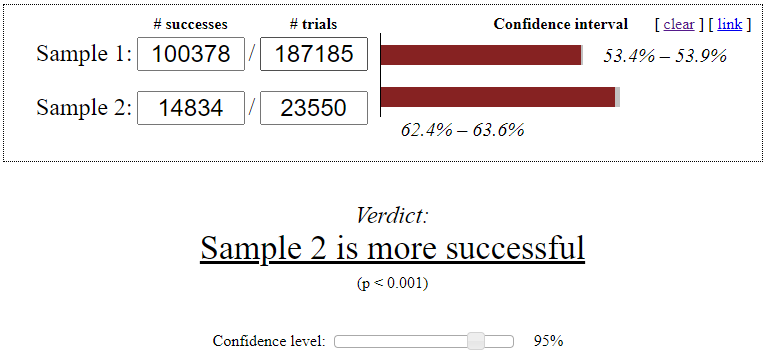

### Conversion Rate

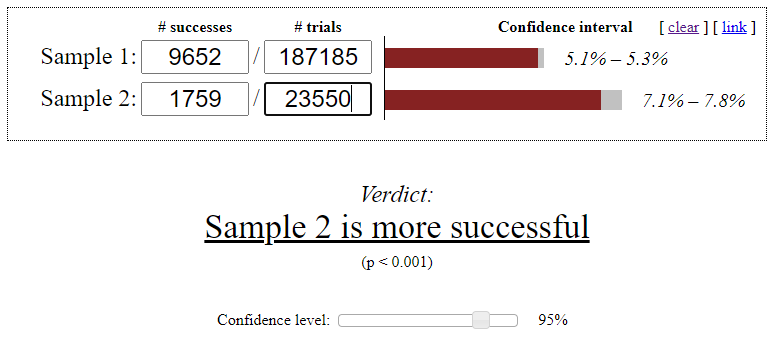

Ссылка на калькулятор: https://www.evanmiller.org/ab-testing/chi-squared.html